## Imports


In [39]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.onnx

## Data loading

In [40]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")


In [41]:
df.shape

(4898, 12)

In [42]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Check if there are any NaN values

In [44]:
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [45]:
fig = px.histogram(df,x='quality')
fig.show()

<AxesSubplot:>

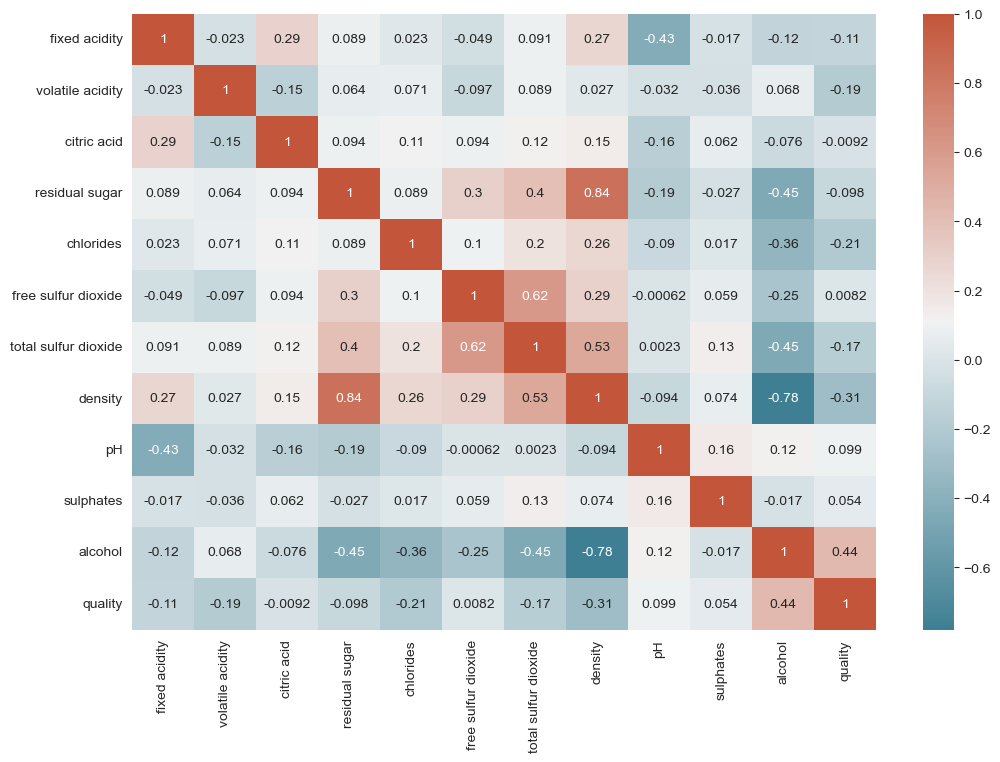

In [46]:
corr = df.corr()
plt.pyplot.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [47]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)
x_train = train.values[:,:-1]
y_train = train.values[:,-1]
x_test = test.values[:,:-1]
y_test = test.values[:,-1]

In [48]:
import torch.utils.data as data

In [49]:
from sklearn.preprocessing import StandardScaler
# x_train = StandardScaler().fit_transform(x_train)
# x_test = StandardScaler().fit_transform(x_test)

In [50]:
train_dataset = data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
next(iter(train_dataset))

(tensor([7.6000e+00, 3.0000e-01, 3.7000e-01, 1.6000e+00, 8.7000e-02, 2.7000e+01,
         1.7700e+02, 9.9438e-01, 3.0900e+00, 5.0000e-01, 9.8000e+00],
        dtype=torch.float64),
 tensor(5., dtype=torch.float64))

In [51]:
train_data_loader = data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [52]:
import torch.nn as nn

In [53]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.activ_func = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ_func(x)
        x = self.linear2(x)

        return x

In [54]:
model = SimpleClassifier(num_inputs=11, num_hidden=16, num_outputs=1)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_module = nn.MSELoss()

In [55]:
model.train()

for epoch in range(100):
    for data_input, data_target in train_data_loader:
        optimizer.zero_grad()
        predictions = model(data_input.float())
        predictions = predictions.squeeze(dim=1)
        loss = loss_module(predictions, data_target.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    # scheduler.step()

Epoch: 0, loss: 0.365
Epoch: 1, loss: 0.451
Epoch: 2, loss: 0.79
Epoch: 3, loss: 0.617
Epoch: 4, loss: 1.29
Epoch: 5, loss: 0.562
Epoch: 6, loss: 0.836
Epoch: 7, loss: 0.786
Epoch: 8, loss: 0.795
Epoch: 9, loss: 0.301
Epoch: 10, loss: 0.337
Epoch: 11, loss: 0.501
Epoch: 12, loss: 0.419
Epoch: 13, loss: 0.202
Epoch: 14, loss: 0.689
Epoch: 15, loss: 0.462
Epoch: 16, loss: 1.15
Epoch: 17, loss: 1.03
Epoch: 18, loss: 0.565
Epoch: 19, loss: 0.333
Epoch: 20, loss: 0.399
Epoch: 21, loss: 0.746
Epoch: 22, loss: 0.661
Epoch: 23, loss: 0.273
Epoch: 24, loss: 0.36
Epoch: 25, loss: 0.963
Epoch: 26, loss: 1.01
Epoch: 27, loss: 0.65
Epoch: 28, loss: 0.218
Epoch: 29, loss: 0.213
Epoch: 30, loss: 0.3
Epoch: 31, loss: 0.84
Epoch: 32, loss: 0.413
Epoch: 33, loss: 0.571
Epoch: 34, loss: 0.111
Epoch: 35, loss: 1.01
Epoch: 36, loss: 0.231
Epoch: 37, loss: 1.21
Epoch: 38, loss: 0.673
Epoch: 39, loss: 0.605
Epoch: 40, loss: 0.533
Epoch: 41, loss: 0.898
Epoch: 42, loss: 0.489
Epoch: 43, loss: 1.68
Epoch: 44, 

In [56]:
test_dataset = data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
next(iter(test_dataset))

(tensor([8.1000e+00, 2.8000e-01, 4.0000e-01, 6.9000e+00, 5.0000e-02, 3.0000e+01,
         9.7000e+01, 9.9510e-01, 3.2600e+00, 4.4000e-01, 1.0100e+01],
        dtype=torch.float64),
 tensor(6., dtype=torch.float64))

In [57]:
test_data_loader = data.DataLoader(test_dataset, batch_size=10, shuffle=True, drop_last=True)

In [59]:
model.eval()
true_predictions, number_of_predictions = 0., 0.

with torch.no_grad():
    for data_input, data_target in test_data_loader:
        predictions = model(data_input.float())
        predictions = predictions.squeeze(dim=1)
        predictions = torch.round(predictions)
        true_predictions += (predictions == data_target).sum()
        number_of_predictions += data_target.shape[0]

acc = true_predictions / number_of_predictions
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 50.31%


In [62]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-0.4482, -0.1873,  0.2355, -0.2579,  0.1346,  0.1422, -0.1579, -0.2740,
         -0.0903, -0.2062, -0.3692],
        [-0.1789,  0.0208, -0.1289, -0.1141, -0.0951, -0.4356, -0.3650, -0.3403,
         -0.2802, -0.2610, -0.0710],
        [ 0.0747,  0.6780, -0.5779, -0.3103,  0.2669, -0.4337, -0.0293,  0.1326,
          0.5554,  0.0690,  0.2926],
        [ 0.0776,  0.0420,  0.3871, -0.1145, -0.1029,  0.2389,  0.4318,  0.4268,
          0.1063, -0.1309,  0.1987],
        [-0.0699, -0.2268, -0.2279,  0.0054,  0.2094, -0.3397, -0.0107, -0.1639,
         -0.0372, -0.2413, -0.2293],
        [-0.5429, -2.0602,  0.3922,  0.0586, -2.6122,  0.0712,  0.0115, -0.5581,
         -0.1729,  0.1786,  0.3076],
        [-0.3083,  0.2064,  0.1400, -0.1744,  0.2092,  0.0899, -0.2993, -0.2811,
          0.0743, -0.2795, -0.3702],
        [ 0.2981,  0.3041, -0.2677,  0.0862,  0.2156,  0.3099,  0.2995, -0.2576,
          0.2298,  0.2831,  0.1672],
        [-0.0039, -0.057

In [63]:
torch.save(state_dict, "wine1.tar")

In [64]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("wine1.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=11, num_hidden=16, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.cpu().state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-0.4482, -0.1873,  0.2355, -0.2579,  0.1346,  0.1422, -0.1579, -0.2740,
         -0.0903, -0.2062, -0.3692],
        [-0.1789,  0.0208, -0.1289, -0.1141, -0.0951, -0.4356, -0.3650, -0.3403,
         -0.2802, -0.2610, -0.0710],
        [ 0.0747,  0.6780, -0.5779, -0.3103,  0.2669, -0.4337, -0.0293,  0.1326,
          0.5554,  0.0690,  0.2926],
        [ 0.0776,  0.0420,  0.3871, -0.1145, -0.1029,  0.2389,  0.4318,  0.4268,
          0.1063, -0.1309,  0.1987],
        [-0.0699, -0.2268, -0.2279,  0.0054,  0.2094, -0.3397, -0.0107, -0.1639,
         -0.0372, -0.2413, -0.2293],
        [-0.5429, -2.0602,  0.3922,  0.0586, -2.6122,  0.0712,  0.0115, -0.5581,
         -0.1729,  0.1786,  0.3076],
        [-0.3083,  0.2064,  0.1400, -0.1744,  0.2092,  0.0899, -0.2993, -0.2811,
          0.0743, -0.2795, -0.3702],
        [ 0.2981,  0.3041, -0.2677,  0.0862,  0.2156,  0.3099,  0.2995, -0.2576,
          0.2298,  0.2831,  0.1672],
        

In [65]:
onnx_input = torch.tensor([7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8])
expected_label = 6.

In [66]:
input_names = df.columns[:-1]
output_names = df.columns[-1]
print(input_names, output_names)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object') quality


In [67]:
torch.onnx.export(model, onnx_input, 'wine_model.onnx', export_params=True, input_names=['input'], output_names=['output'])